In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle

In [20]:
# Load data and Oracle
oracle = Oracle(name='DRD2')
training_data = pd.read_csv("../data/drd2_final_train_small.csv")
testing_data = pd.read_csv("../data/drd2_final_test_small.csv")
smiles_train = training_data['smiles'].tolist()
smiles_test = testing_data['smiles'].tolist()
label_proba_train = [oracle(smiles) for smiles in smiles_train]
label_proba_test = [oracle(smiles) for smiles in smiles_test]
print(f"Training data len: {len(smiles_train)}")
print(f"Testing data len: {len(smiles_test)}")

Found local copy...


Training data len: 200
Testing data len: 200


### Computing morgan fingerprints

In [21]:
def compute_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    else:
        return np.zeros((2048,), dtype=int)

features_train = torch.tensor([compute_fingerprints(smiles) for smiles in smiles_train])
features_test = torch.tensor([compute_fingerprints(smiles) for smiles in smiles_test])
label_proba_train = torch.tensor(label_proba_train)
label_proba_test = torch.tensor(label_proba_test)
label_binary_train = torch.tensor(training_data["label"].to_numpy())
label_binary_test = torch.tensor(testing_data["label"].to_numpy())

print("features_train shape: ", features_train.shape)
print("label_proba_train shape: ", label_proba_train.shape)
print("label_binary_train shape: ", label_binary_train.shape)

print("features_test shape: ", features_test.shape)
print("label_proba_test shape: ", label_proba_test.shape)
print("label_binary_test shape: ", label_binary_test.shape)

features_train shape:  torch.Size([200, 2048])
label_proba_train shape:  torch.Size([200])
label_binary_train shape:  torch.Size([200])
features_test shape:  torch.Size([200, 2048])
label_proba_test shape:  torch.Size([200])
label_binary_test shape:  torch.Size([200])


### Generate pairs and labels

In [22]:
def generate_pairs_label(features, label_proba, label_binary, smiles_list, num_sets=1000):
    # set seed
    np.random.seed(42) 
    from itertools import product
    # Generate all repeated combinations of 2 out of len(smiles)

    smiles_len, features_dim = features.shape
    comb = list(product(range(smiles_len), repeat=2))

    # Remove indices that compare to itself
    comb = [(i, j) for (i, j) in comb if i != j]

    rng = np.random.default_rng()
    
    chosen_indices = rng.choice(len(comb), num_sets, replace=False)
    
    chosen_comb = [comb[i] for i in chosen_indices]

    features_1 = np.zeros((num_sets, features_dim))
    features_2 = np.zeros((num_sets, features_dim))
    smiles_1 = []
    smiles_2 = []
    label_1_proba = []
    label_1_binary = []
    label_2_proba = []
    label_2_binary = []
    compare_proba = []
    compare_binary = []

    for i, (idx1, idx2) in enumerate(chosen_comb):
        features_1[i, :] = features[idx1, :]
        features_2[i, :] = features[idx2, :]
        smiles_1.append(smiles_list[idx1])
        smiles_2.append(smiles_list[idx2])
        label_1_proba.append(label_proba[idx1])
        label_1_binary.append(label_binary[idx2])
        label_2_proba.append(label_proba[idx1])
        label_2_binary.append(label_binary[idx2])
        # convert to float
        compare_proba_value = torch.tensor(label_proba[idx1] - label_proba[idx2], dtype=torch.float32)
        compare_proba_value = torch.sigmoid(compare_proba_value)
        compare_proba.append(compare_proba_value)
        compare_binary.append(1 if compare_proba_value > 0.5 else 0)

    # Convert to numpy
    label_1_proba = np.array(label_1_proba)
    label_1_binary = np.array(label_1_binary)
    label_2_proba = np.array(label_2_proba)
    label_2_binary = np.array(label_2_binary)
    compare_proba = np.array(compare_proba)
    compare_binary = np.array(compare_binary)
    smiles_1 = np.array(smiles_1)
    smiles_2 = np.array(smiles_2)

    return features_1, features_2, label_1_proba, label_1_binary, label_2_proba, label_2_binary,\
            compare_proba, compare_binary, smiles_1, smiles_2

features_1_train, features_2_train, label_1_proba_train, label_1_binary_train, label_2_proba_train, label_2_binary_train,\
compare_proba_train, compare_binary_train, smiles_1_train, smiles_2_train = generate_pairs_label(features_train, label_proba_train, label_binary_train, smiles_train, num_sets=len(smiles_train))

features_1_test, features_2_test, label_1_proba_test, label_1_binary_test, label_2_proba_test, label_2_binary_test,\
compare_proba_test, compare_binary_test, smiles_1_test, smiles_2_test = generate_pairs_label(features_test, label_proba_test, label_binary_test, smiles_test, num_sets=len(smiles_test))    

In [23]:
print(features_1_train.shape, features_1_test.shape)
print(features_2_train.shape, features_2_test.shape)
print(label_1_proba_train.shape, label_1_proba_test.shape)
print(label_1_binary_train.shape, label_1_binary_test.shape)
print(label_2_proba_train.shape, label_2_proba_test.shape)
print(label_2_binary_train.shape, label_2_binary_test.shape)
print(compare_proba_train.shape, compare_proba_test.shape)
print(compare_binary_train.shape, compare_binary_test.shape)

(200, 2048) (200, 2048)
(200, 2048) (200, 2048)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)


In [24]:
# Now we need to save them 

small_drd2_training_data = pd.DataFrame()
small_drd2_training_data['smiles_1'] = smiles_1_train
small_drd2_training_data['smiles_2'] = smiles_2_train
small_drd2_training_data['label_1_proba'] = label_1_proba_train
small_drd2_training_data['label_2_proba'] = label_2_proba_train
small_drd2_training_data['label_1_binary'] = label_1_binary_train
small_drd2_training_data['label_2_binary'] = label_2_binary_train
small_drd2_training_data['compare_proba'] = compare_proba_train
small_drd2_training_data['compare_binary'] = compare_binary_train

small_drd2_training_data.to_csv("small_drd2_training_data.csv", index=False)

small_drd2_testing_data = pd.DataFrame()
small_drd2_testing_data['smiles_1'] = smiles_1_test
small_drd2_testing_data['smiles_2'] = smiles_2_test
small_drd2_testing_data['label_1_proba'] = label_1_proba_test
small_drd2_testing_data['label_2_proba'] = label_2_proba_test
small_drd2_testing_data['label_1_binary'] = label_1_binary_test
small_drd2_testing_data['label_2_binary'] = label_2_binary_test
small_drd2_testing_data['compare_proba'] = compare_proba_test
small_drd2_testing_data['compare_binary'] = compare_binary_test

small_drd2_testing_data.to_csv("small_drd2_testing_data.csv", index=False)

### Use proba label to train. Probably a correct approach

In [31]:
from bradley_terry import BradleyTerryModel
    
# Training the model
model = BradleyTerryModel(feature_dim=2048)

# When using Binary Cross-Entropy Loss (BCELoss) in neural networks, the input expected by the 
# loss function is a list of probabilities, not binary values (0 or 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

from torch.utils.data import TensorDataset, DataLoader

features_1_train_tensor = torch.tensor(features_1_train).float()  
features_2_train_tensor = torch.tensor(features_2_train).float()
compare_proba_train_tensor = torch.tensor(compare_proba_train).float()

features_1_test_tensor = torch.tensor(features_1_test).float()
features_2_test_tensor = torch.tensor(features_2_test).float()
compare_proba_test_tensor = torch.tensor(compare_proba_test).float()

# Create a TensorDataset
train_dataset = TensorDataset(features_1_train_tensor, features_2_train_tensor, 
                              compare_proba_train_tensor)
test_dataset = TensorDataset(features_1_test_tensor, features_2_test_tensor, 
                              compare_proba_test_tensor)

# Create a DataLoader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def train(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for features_1, features_2, compare_binary in train_loader:
            optimizer.zero_grad()
            output = model(features_1, features_2)
            loss = criterion(output, compare_binary.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss / len(features_1)}')

train(model, train_loader)

# save state dict
torch.save(model.state_dict(), "bradley_terry_model.pth")

print("Model trained and saved")

Epoch 5, Loss: 0.6064228937029839
Model trained and saved


### Perform prediction on the testing dataset

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(label, predictions):
    """
    Compute classification metrics: accuracy, precision, recall, F1 score, and MCC.
    
    Args:
    label (list[int]): True binary label.
    predictions (list[int]): Predicted binary label.

    Returns:
    dict: A dictionary containing the computed metrics.
    """
    accuracy = accuracy_score(label, predictions)
    precision = precision_score(label, predictions)
    recall = recall_score(label, predictions)
    f1 = f1_score(label, predictions)
    mcc = matthews_corrcoef(label, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'MCC': mcc
    }

### Prediction using the feedback

In [33]:
# Initialize the model
model = BradleyTerryModel(feature_dim=2048)

# Load the state dict
model.load_state_dict(torch.load("bradley_terry_model.pth"))

from scripts.predict import predict_feedback_from_model

batch_pred = 10000
print("Expected number of batches")
print(int(np.ceil(int(len(smiles_test) * (len(smiles_test) - 1))/batch_pred)))

pred_label_feedback_test = predict_feedback_from_model(feedback_type = "comparing", 
                                                 feedback_model = model, 
                                                 smiles=smiles_test, batch_pred=batch_pred)


pred_label_binary_test = (torch.tensor(pred_label_feedback_test) > 0.5).int().tolist()

metrics = compute_metrics(label_binary_test, pred_label_binary_test)

assert all([0 <= x <= 1 for x in pred_label_feedback_test]), "Feedback score should be between 0 and 1"

print("\nAccuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['F1'])
print("MCC:", metrics['MCC'])

Expected number of batches
4
B1 processed | B2 processed | B3 processed | B4 processed | 
Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1: 0.56
MCC: 0.12


### Plot the roc curve using the feedback

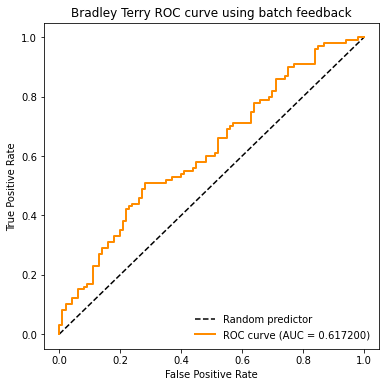

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(label_binary_test, pred_label_feedback_test, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))

# draw a diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random predictor")

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.6f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bradley Terry ROC curve using batch feedback')

plt.legend(loc="lower right", frameon=False)

### Prediction using the label probability

In [35]:
# Initialize the model
model = BradleyTerryModel(feature_dim=2048)

# Load the state dict
model.load_state_dict(torch.load("bradley_terry_model.pth"))

from scripts.predict import predict_proba_from_model

pred_label_proba_test = predict_proba_from_model(feedback_type = "comparing", 
                                                 feedback_model = model, 
                                                 smiles=smiles_test)


pred_label_binary_test = (torch.tensor(pred_label_proba_test) > 0.5).int().tolist()

metrics = compute_metrics(label_binary_test, pred_label_binary_test)

assert all([0 <= x <= 1 for x in pred_label_proba_test]), "Probability should be between 0 and 1"

print("\nAccuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['F1'])
print("MCC:", metrics['MCC'])


Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1: 0.6666666666666666
MCC: 0.0


### Plot the roc curve using the label probability

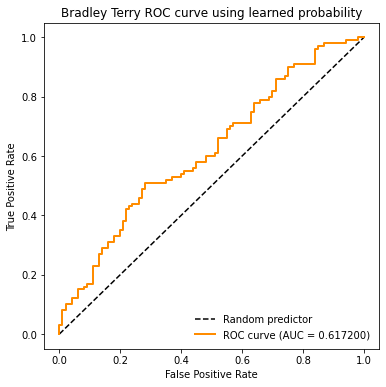

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(label_binary_test, pred_label_proba_test, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))

# draw a diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random predictor")

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.6f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bradley Terry ROC curve using learned probability')

plt.legend(loc="lower right", frameon=False)

#### The model performs weakly, which means that we can now use this model as a human component for HITL. Ideally, the initial model should be no better than random guess. Additionally, the AUC of both feedback and label probability are similar, which means that the feedback is valid for REINVENT